In [7]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum > /dev/null

In [8]:
import pandas as pd
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import platform

# if platform.system() == 'Windows':
# # 윈도우인 경우
#     font_name = font_manager.FontProperties(fname="/content/malgun.ttf").get_name()
#     rc('font', family=font_name)
# else:    
# # Mac 인 경우
#     font_name = font_manager.FontProperties(fname='/content/AppleGothic.ttf').get_name()
#     rc('font', family=font_name)

In [40]:
def load_dataset(): 
    sales = pd.read_excel("sales.xlsx",header =1,encoding="CP949")
    sales_2020 = pd.read_csv('/content/2020 nsshop+.csv',encoding="CP949")
    view_rate = pd.read_excel("view_rate.xlsx",header =1, index_col= 0,encoding="CP949")
    return sales, view_rate, sales_2020

sales = load_dataset()[0]
view_rate = load_dataset()[1]
sales_2020 = load_dataset()[2]

In [ ]:
sales.head()

In [ ]:
view_rate.head()

# 데이터 전처리

In [ ]:
## TODO 
## 1.무형 상품은 추정 제외 
## 2.결측된 노출분 채우기 (직전의 값 집어넣기) 
## 3. 판매단가 > 취급액이면 취급액 0 
##

def custom(price, total):
    # 3전처리 
    if price > total: return 0
    else: return total

def pre_processing(df): 
    # 1. 무형 상품 추정 제외 
    df = df.drop(df[df["상품군"]=="무형"].index,axis = 0)
    # 2. 결측된 노출분 채우기 
    for i,row in df.iterrows():
        val = row["노출(분)"]
        if i == 0:
            continue 
        if np.isnan(val):
            if df.loc[i,"방송일시"] == df.loc[i-1,"방송일시"]:
                df.loc[i,"노출(분)"] = df.loc[i-1,"노출(분)"]
            else :
                continue 
                
    # 3. 판매단가 > 취급액이면 취급액 0 
    df["취급액"] = df.apply(lambda x : custom(x["판매단가"], x["취급액"]),axis=1)
    print(sum((sales["판매단가"] > sales["취급액"]) & (sales['취급액'] != 0)))
    # 4. month, day, hour, minute, weekday 열 추가 
    df["방송일시"] = pd.to_datetime(df["방송일시"])
    df['month'] = pd.DatetimeIndex(df['방송일시']).month
    df['day'] = pd.DatetimeIndex(df['방송일시']).day
    df['hour'] = pd.DatetimeIndex(df['방송일시']).hour
    df['minute'] = pd.DatetimeIndex(df['방송일시']).minute
    df['weekday'] = pd.DatetimeIndex(df['방송일시']).weekday
    
    # reset_index
    df = df.reset_index(drop=True)
    
    return df 

sales = pre_processing(sales)
sales.head()

In [ ]:
#  상품명을 기준으로 방송 노출 시간 feature 만들기
sales["방송노출시간"] = sales["노출(분)"].values


name_list = sales["상품명"].value_counts().index

for name in name_list:
    df = sales[sales["상품명"]==name]
    for i,index in enumerate(df.index):
        if i == len(df.index)-1:
            continue
        
        else:   
            next_ = df.index[i+1]
            try:
                if (sales.loc[index,"month"]==sales.loc[next_,"month"]) & (sales.loc[index,"day"]==sales.loc[next_,"day"]) & (sales.loc[index,"hour"]==sales.loc[next_,"hour"]) & (sales.loc[index,"minute"]!=sales.loc[next_,"minute"]):
                    sales.loc[next_,"방송노출시간"] = sales.loc[index,"방송노출시간"]+sales.loc[next_,"노출(분)"]
            except:
                continue
    
sales.head()

## 공휴일 feature 추가 


In [ ]:
from datetime import date 
#빨강날~ 
hol= ['2019-01-01'
,'2019-02-04'
,'2019-02-05'
,'2019-02-06'
,'2019-03-01'
,'2019-05-05'
,'2019-05-06'
,'2019-05-12'
,'2019-06-06'
,'2019-08-15'
,'2019-09-12'
,'2019-09-13'
,'2019-09-14'
,'2019-10-03'
,'2019-10-09'
,'2019-12-25',
'2020-01-01']
sales["방송일시"] = pd.to_datetime(sales["방송일시"])
sales["방송날짜"] = sales["방송일시"].apply(lambda x : str(date(x.year,x.month,x.day).isoformat()))
# 1이면 공휴일 아니면 0
sales['holiday']=(sales['방송날짜'].isin(hol)).astype(int)
sales.head()

In [15]:
# 판매량 feature
sales["판매량"] = sales["취급액"]/sales["판매단가"]

In [ ]:
sales.head()

In [67]:
## 상품군 무형 제거
sales_2020.drop(sales_2020[sales_2020["상품군"]=='무형'].index,inplace=True)

## 2020년 1 ~ 5월까지 상품 편성 전처리
##  month, day, hour, minute, weekday 열 추가
def pre_processing(df): 
    df["방송일시"] = pd.to_datetime(df["방송일시"])
    df['month'] = pd.DatetimeIndex(df['방송일시']).month
    df['day'] = pd.DatetimeIndex(df['방송일시']).day
    df['hour'] = pd.DatetimeIndex(df['방송시간']).hour
    df['minute'] = pd.DatetimeIndex(df['방송시간']).minute
    df['weekday'] = pd.DatetimeIndex(df['방송일시']).weekday
    
    return df 

sales_2020 = pre_processing(sales_2020)

In [18]:
sales_2020.head()

,방송일시,방송시간,상품명,상품군,판매단가,month,day,hour,minute,weekday
2,2020-01-01,2:20,(일시불)황금관절4개월분,건강기능,157000,1,1,2,20,2
3,2020-01-01,3:20,KF94엔웰스황사방역마스크100매,생활용품,57900,1,1,3,20,2
5,2020-01-01,6:20,굿프렌드스트레칭안마매트GOOD-A7,생활용품,199000,1,1,6,20,2
6,2020-01-01,7:20,마르엘라로사티에코무스탕1종,의류,78000,1,1,7,20,2
7,2020-01-01,8:21,오델로여성겨울모자3종,잡화,28800,1,1,8,21,2


In [19]:
def plot_pie(value, index , title):
    fig, ax = plt.subplots(figsize = [10,8])
    
    plt.rcParams['text.color'] = 'k'
    plt.rcParams['axes.labelcolor']= '#909090'
    plt.rcParams['xtick.color'] = '#909090'
    plt.rcParams['ytick.color'] = '#909090'
    plt.rcParams['font.size']=10
    # plt.rcParams["font.family"] = 'NanumBarunGothic.ttf'
    plt.rc('font', family='NanumBarunGothic') 
    labels = index # list형태
    values = value# list형태

    plt.pie(values, labels = labels,autopct = "%0.2f%%",shadow =False, startangle =0, pctdistance =1.10, labeldistance = 0.5)
    plt.axis("equal")
    plt.title(title)
    plt.legend(frameon=False, bbox_to_anchor=(1.5,0.8))

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.font_manager as fm
font_list = fm.findSystemFonts()
font_list[:5]
a = fm.FontProperties(fname=font_list[0])
a.get_name()

In [55]:
# 동일 시간대 상품 개수 구하기 
for i in range(1,new_sales.shape[0]):
  if new_sales['마더코드'].iloc[i] == new_sales['마더코드'].iloc[i-1]:
    continue
  new_sales['count'].iloc[i] =1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [58]:
new_sales.head()

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,month,day,hour,minute,weekday,count
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,1,1,6,0,1,1
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,1,1,6,0,1,0
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,1,1,6,20,1,0
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,1,1,6,20,1,0
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,1,1,6,40,1,0


In [60]:
new_sales.to_csv('상품명 정리.csv',encoding='CP949')

In [71]:
new_sales[new_sales['month']==1].groupby('상품군').sum()['count']

상품군
가전       49
건강기능     17
농수축     153
생활용품     24
속옷      108
의류      101
이미용      31
잡화       24
주방      109
Name: count, dtype: int64

Index(['가전', '건강기능', '농수축', '생활용품', '속옷', '의류', '이미용', '잡화', '주방'], dtype='object', name='상품군')
[ 49  17 153  24 108 101  31  24 109]
Index(['가구', '가전', '건강기능', '농수축', '생활용품', '속옷', '의류', '이미용', '잡화', '주방'], dtype='object', name='상품군')
[  8  37  25 130  64  43  83  92  69  82]
Index(['가구', '가전', '건강기능', '농수축', '생활용품', '속옷', '의류', '이미용', '잡화', '주방'], dtype='object', name='상품군')
[ 17  60  14  94  33  79  86  30  40 106]
Index(['가구', '가전', '건강기능', '농수축', '생활용품', '속옷', '의류', '이미용', '잡화', '주방', '침구'], dtype='object', name='상품군')
[  6  40  23 127  39  55  60  81  98  79   4]
Index(['가구', '가전', '건강기능', '농수축', '생활용품', '속옷', '의류', '이미용', '잡화', '주방'], dtype='object', name='상품군')
[ 22  54  18  69  60 102 206  20  56  92]
Index(['가구', '가전', '건강기능', '농수축', '생활용품', '속옷', '의류', '이미용', '잡화', '주방', '침구'], dtype='object', name='상품군')
[ 11  32  23 210  66 128 109  67 106  72   4]
Index(['가구', '가전', '건강기능', '농수축', '생활용품', '속옷', '의류', '이미용', '잡화', '주방', '침구'], dtype='object', name='상품군')
[ 24  61  10  57  

No handles with labels found to put in legend.


Index(['가구', '가전', '건강기능', '농수축', '생활용품', '속옷', '의류', '이미용', '잡화', '주방', '침구'], dtype='object', name='상품군')
[ 21  38  26  70  23 118 114  22  46  85  18]
Index([], dtype='object', name='상품군')
[]


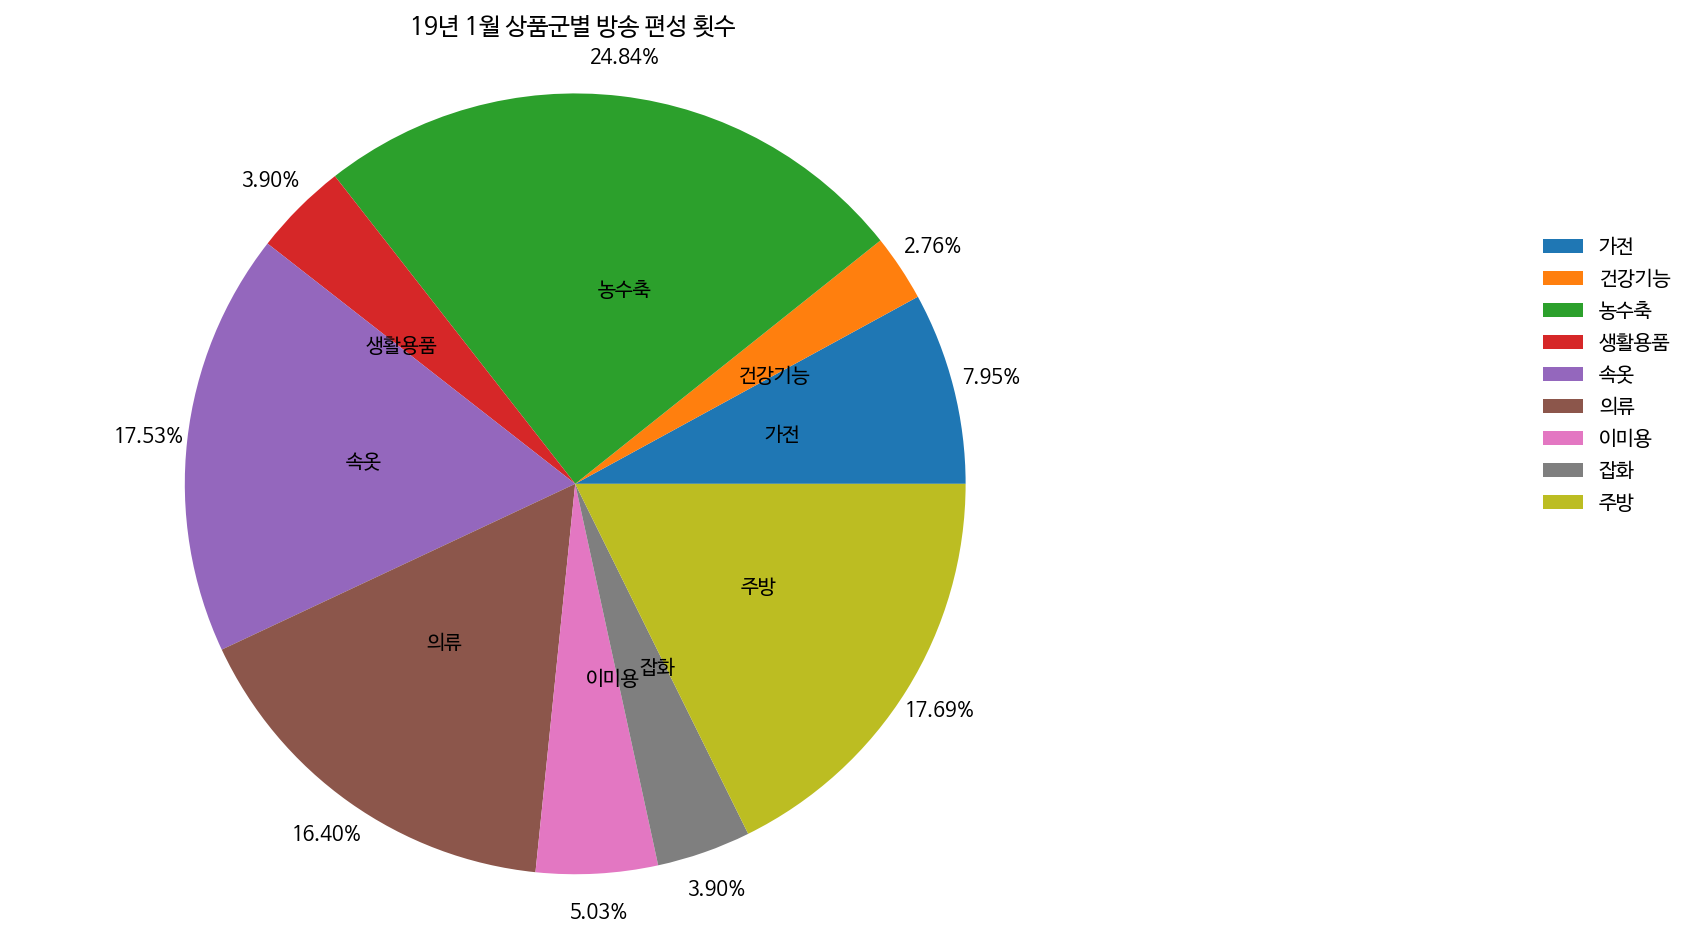

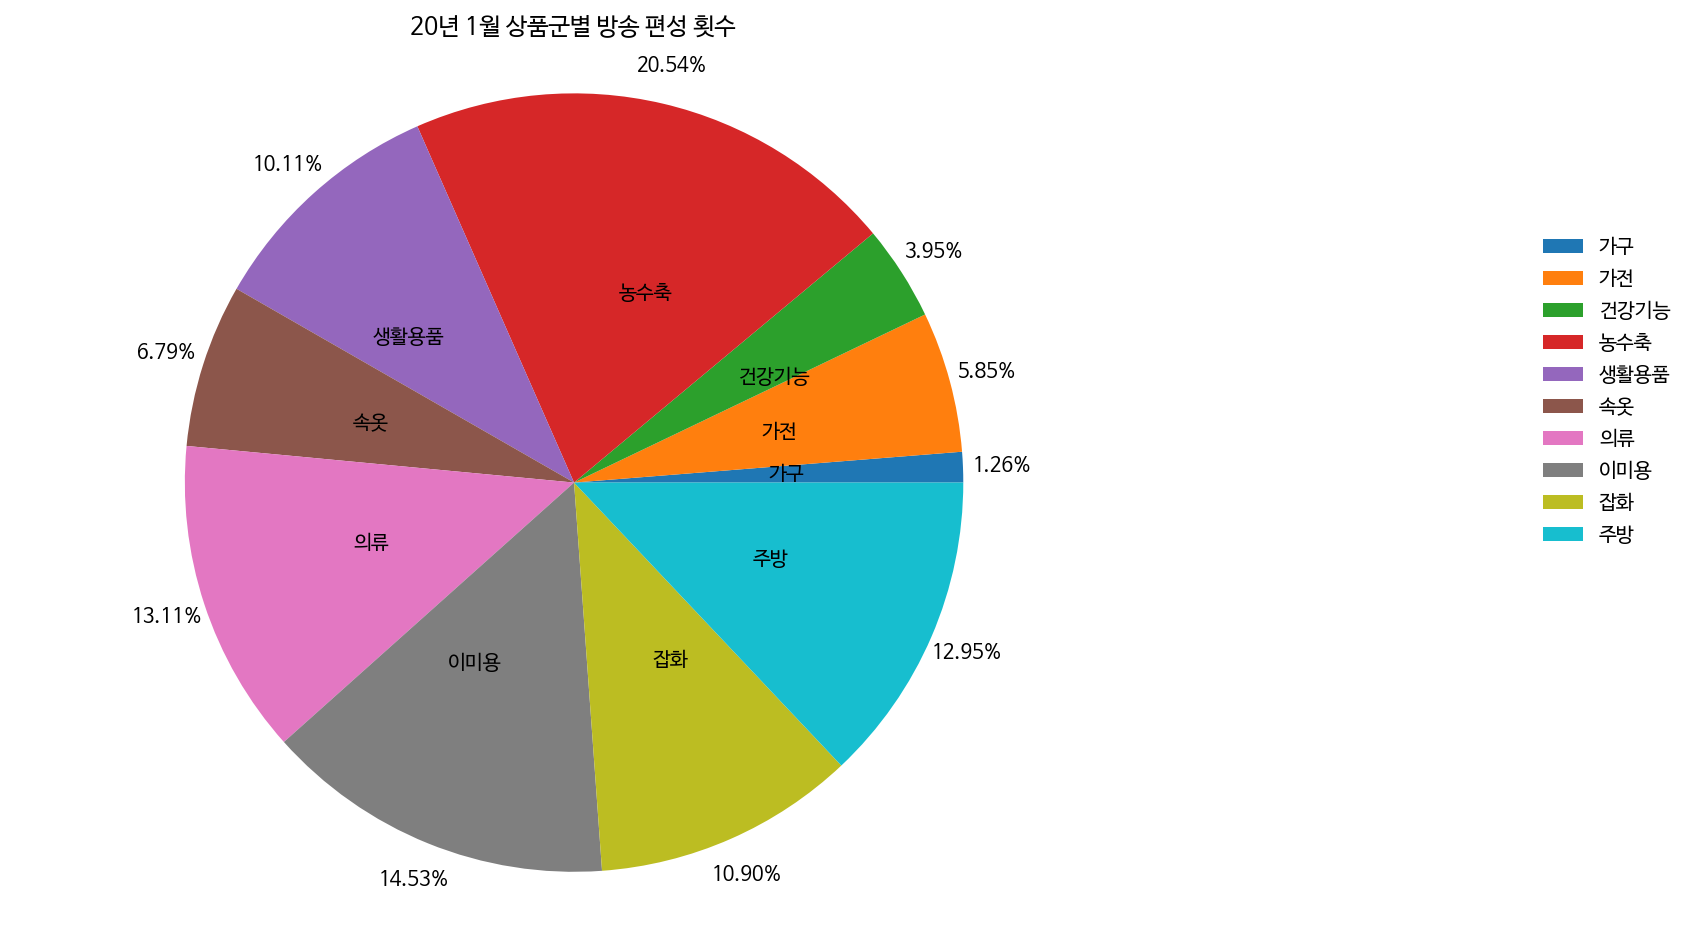

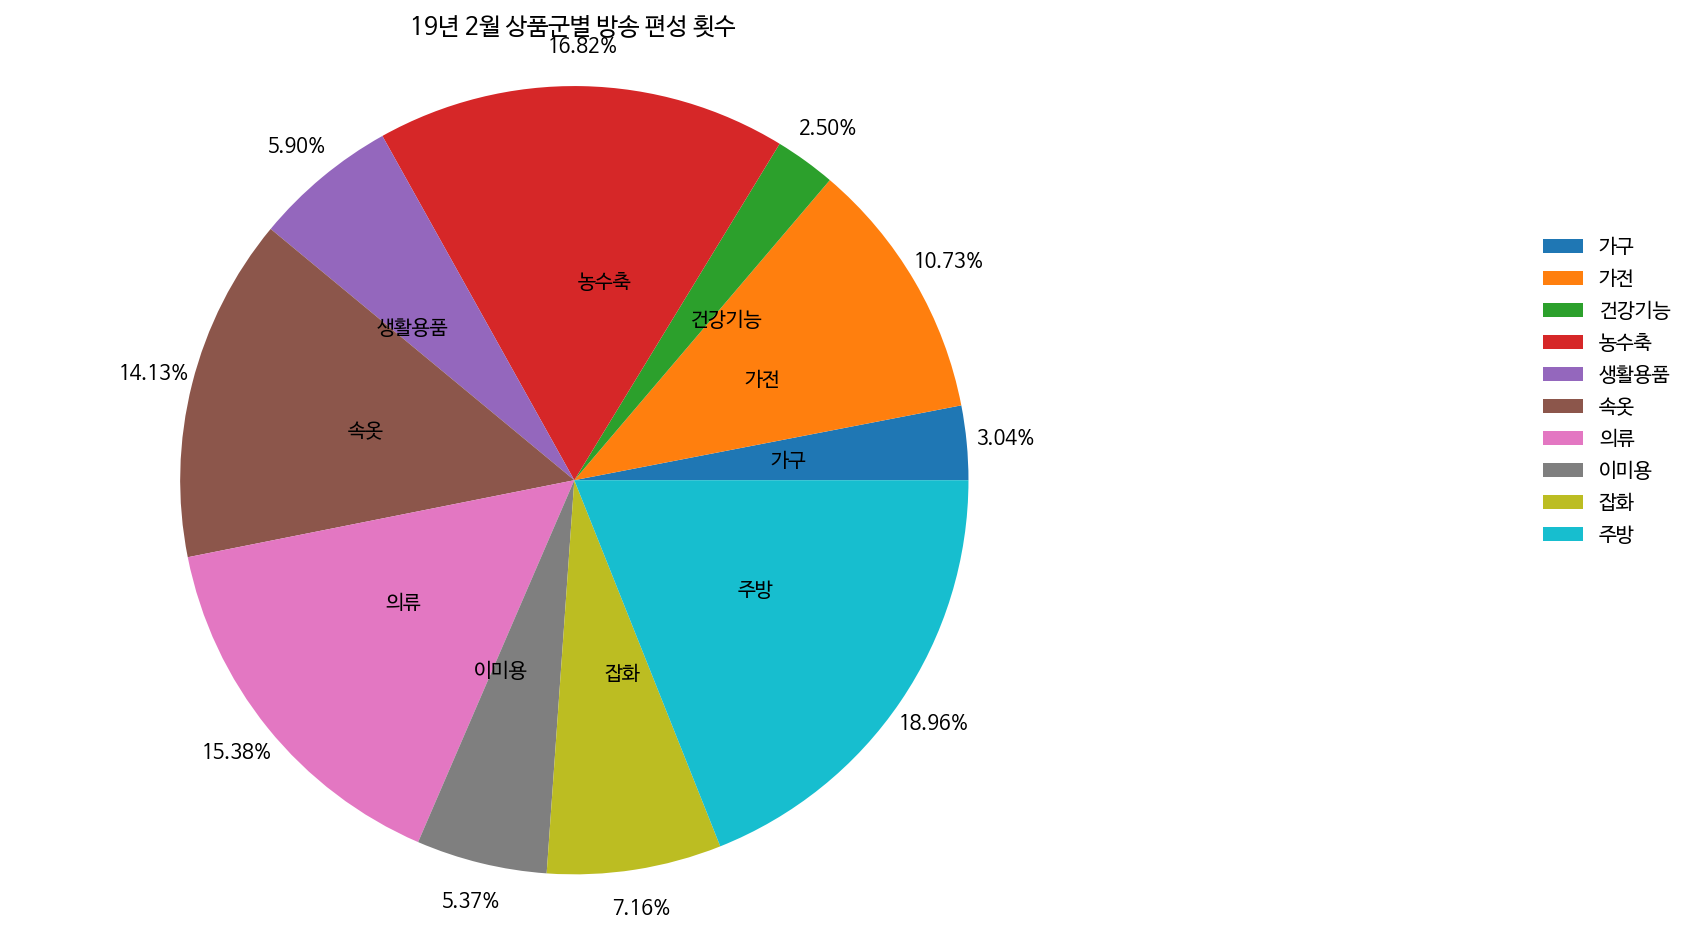

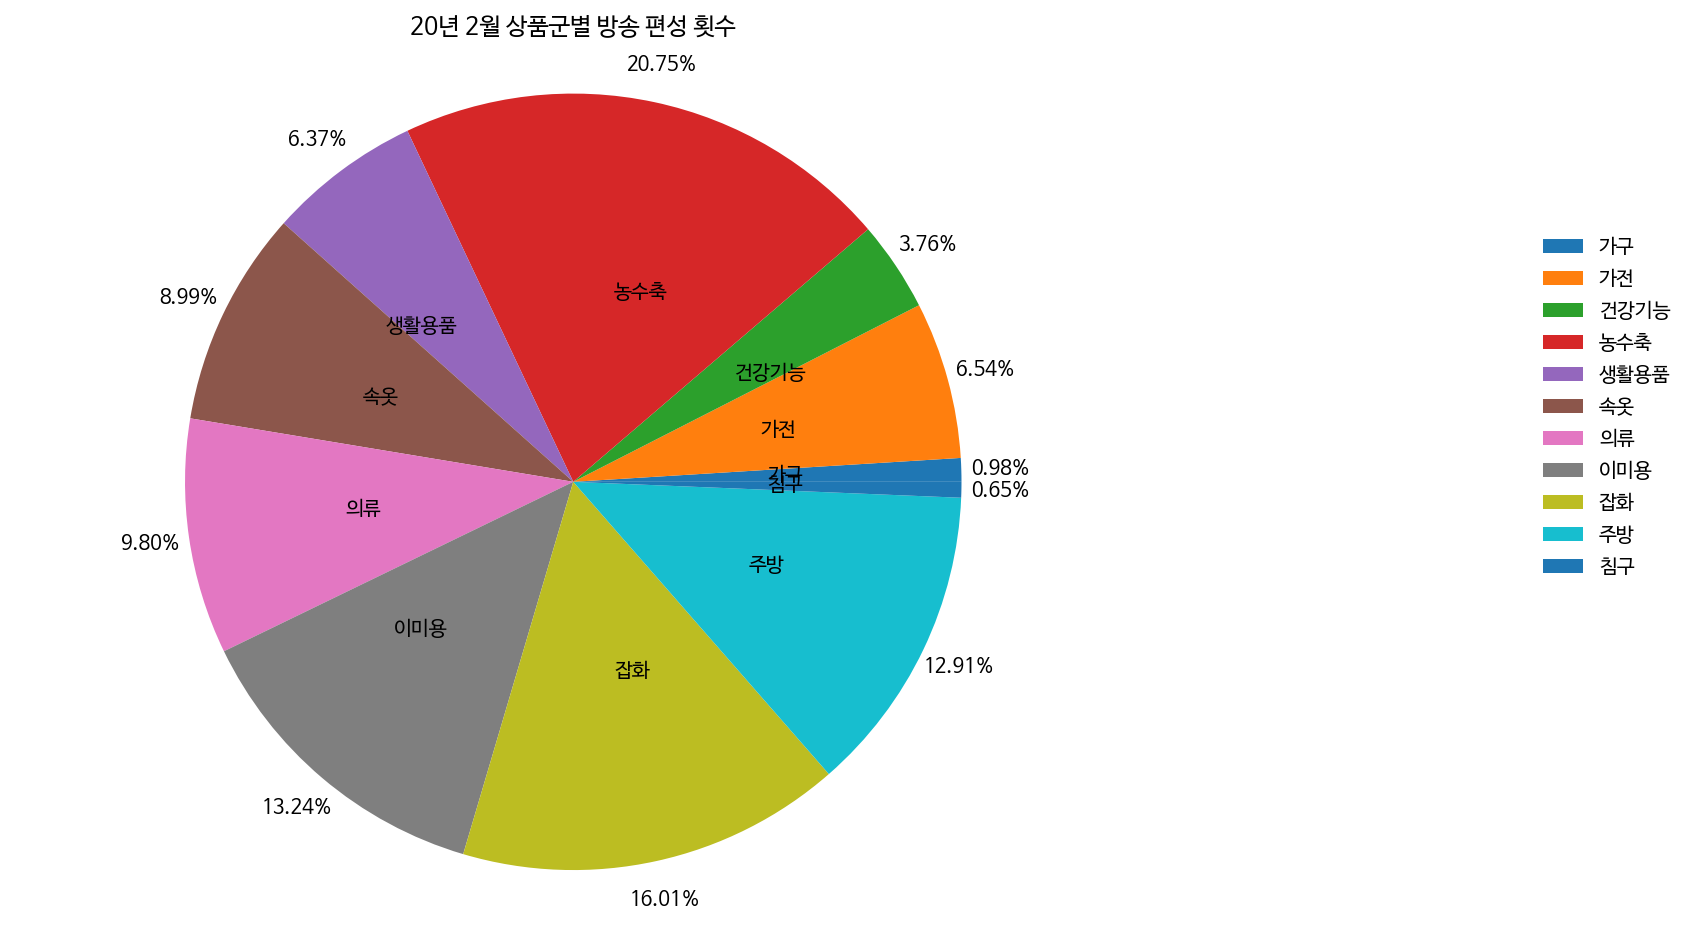

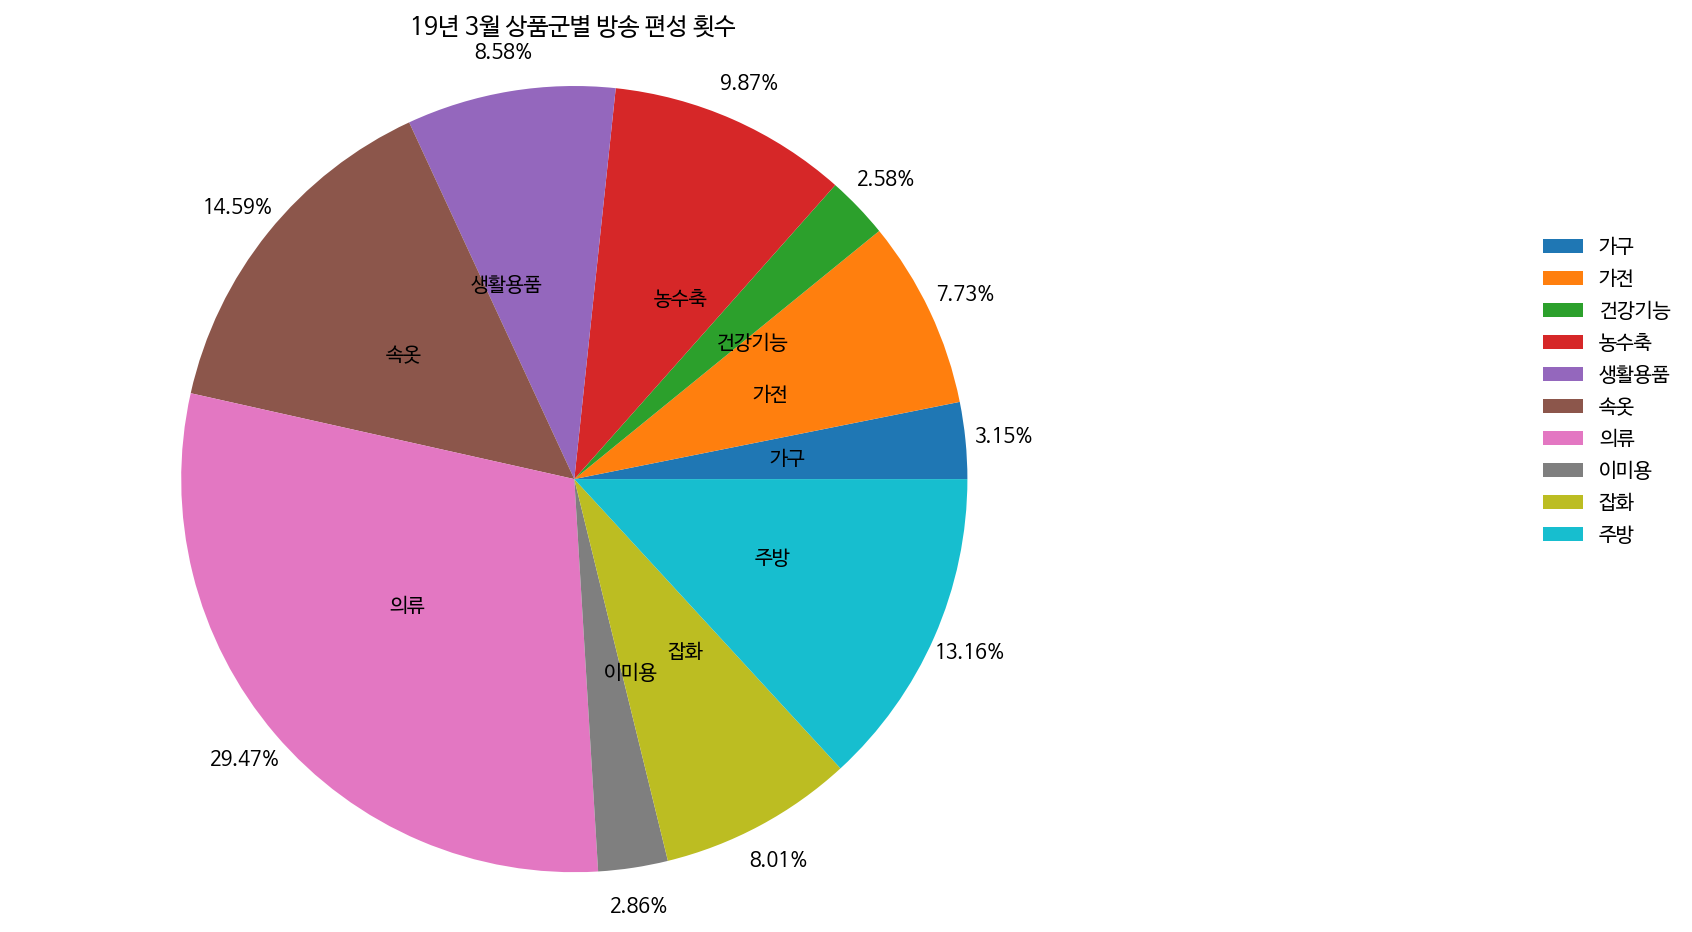

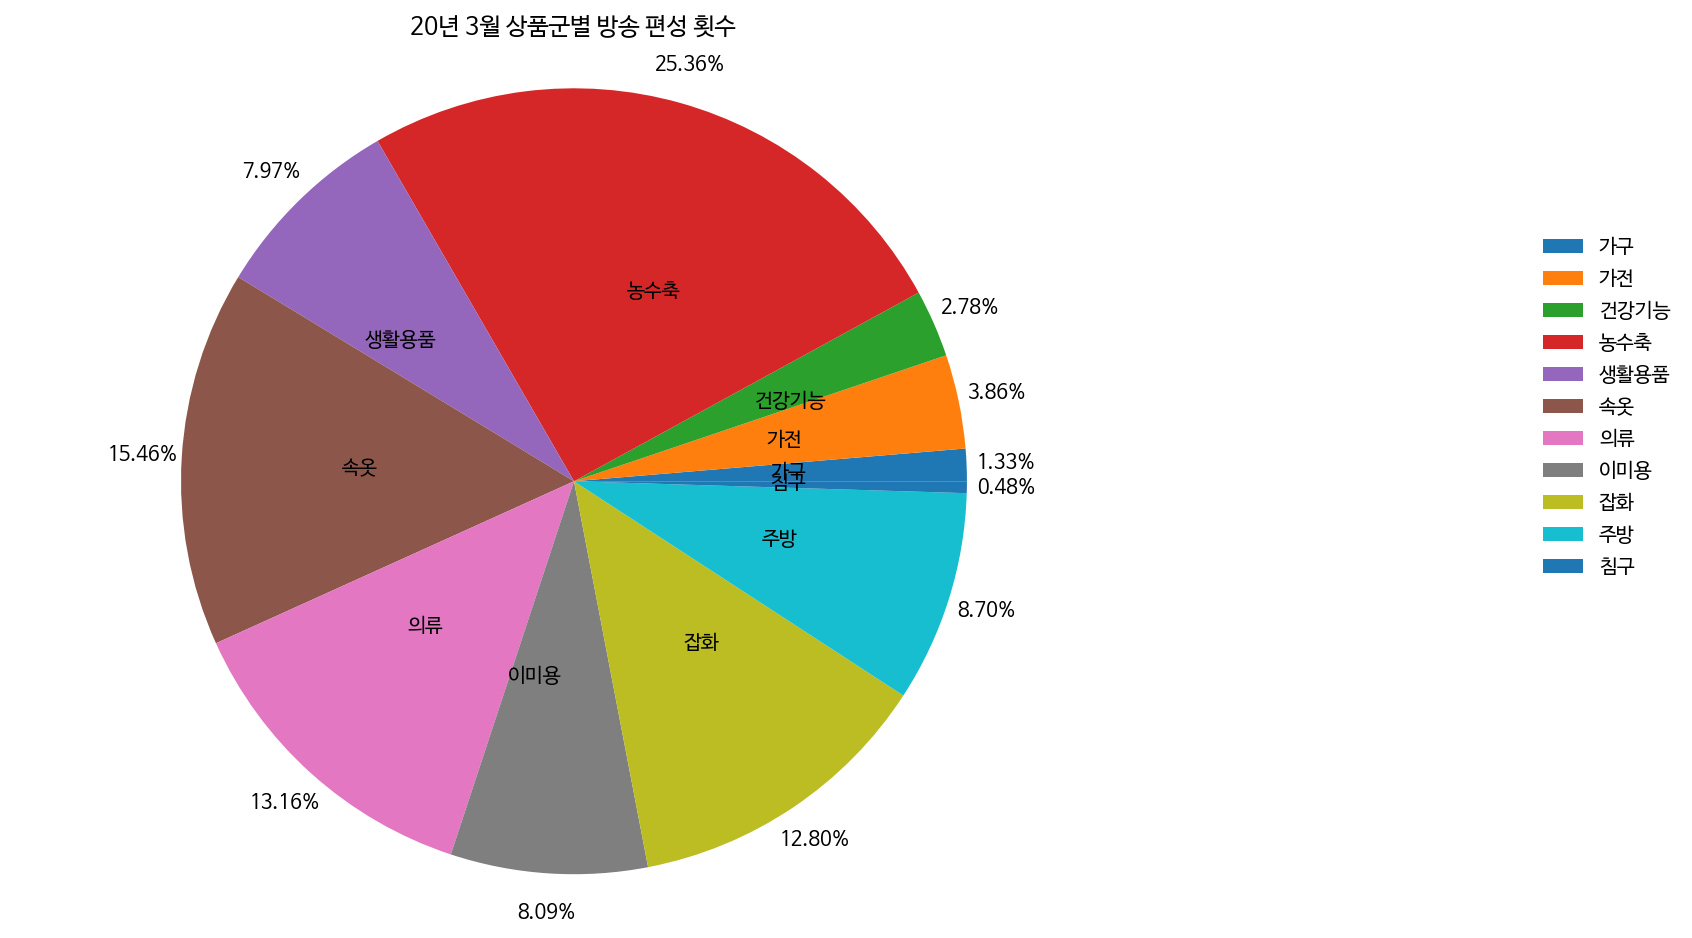

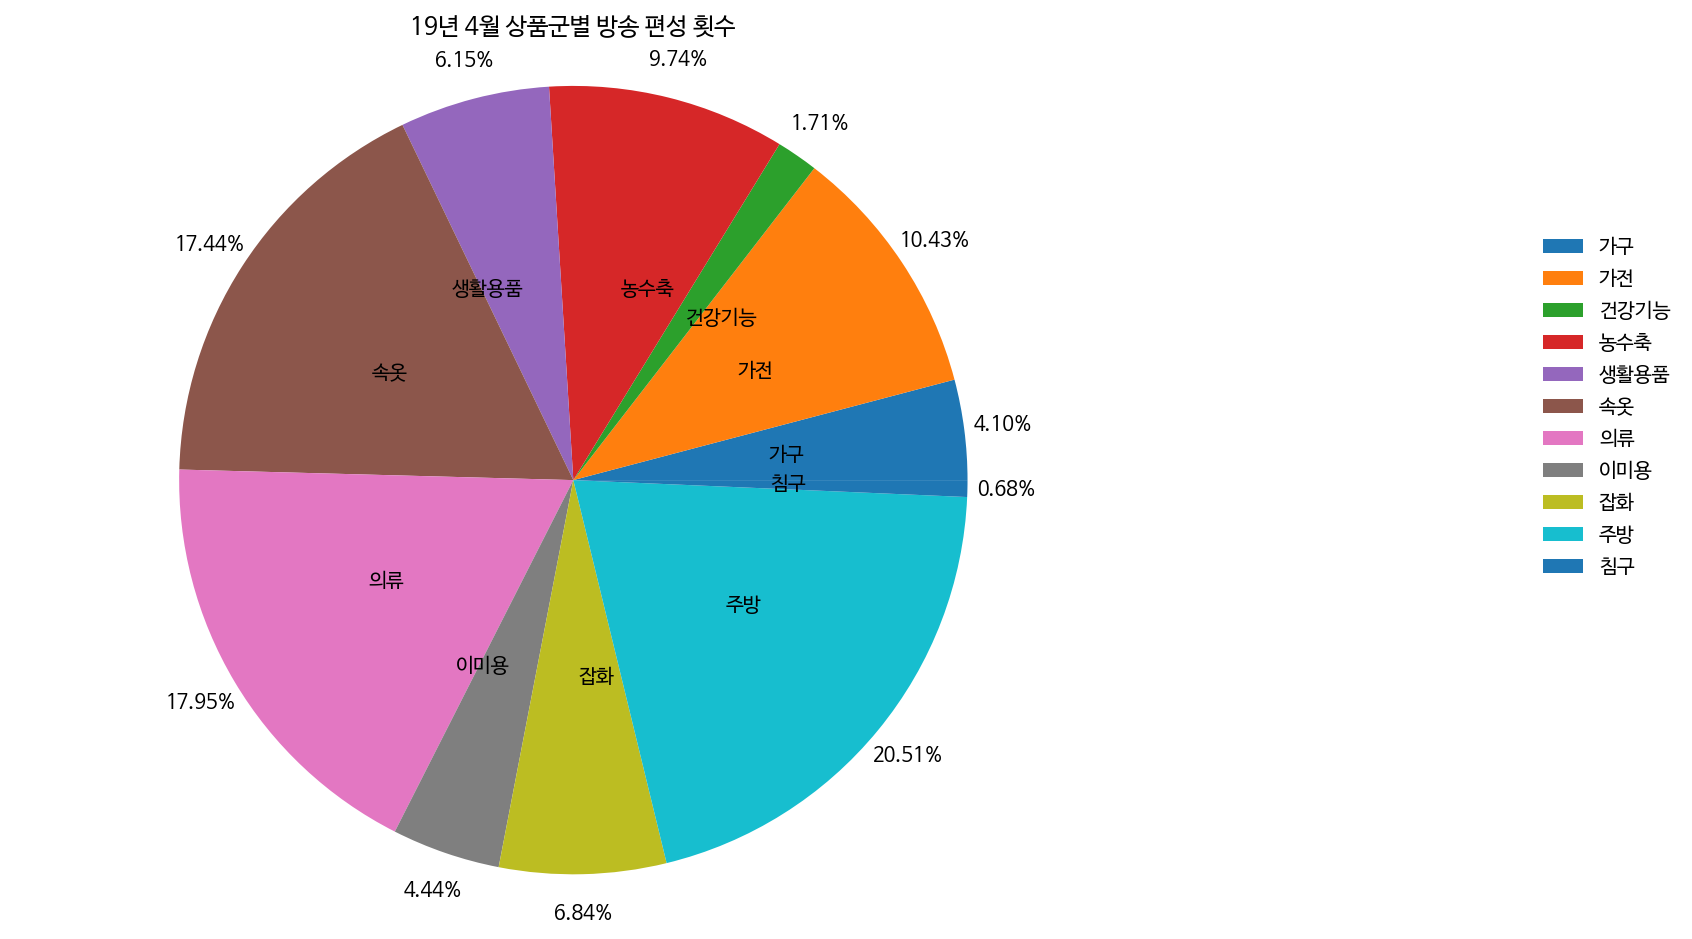

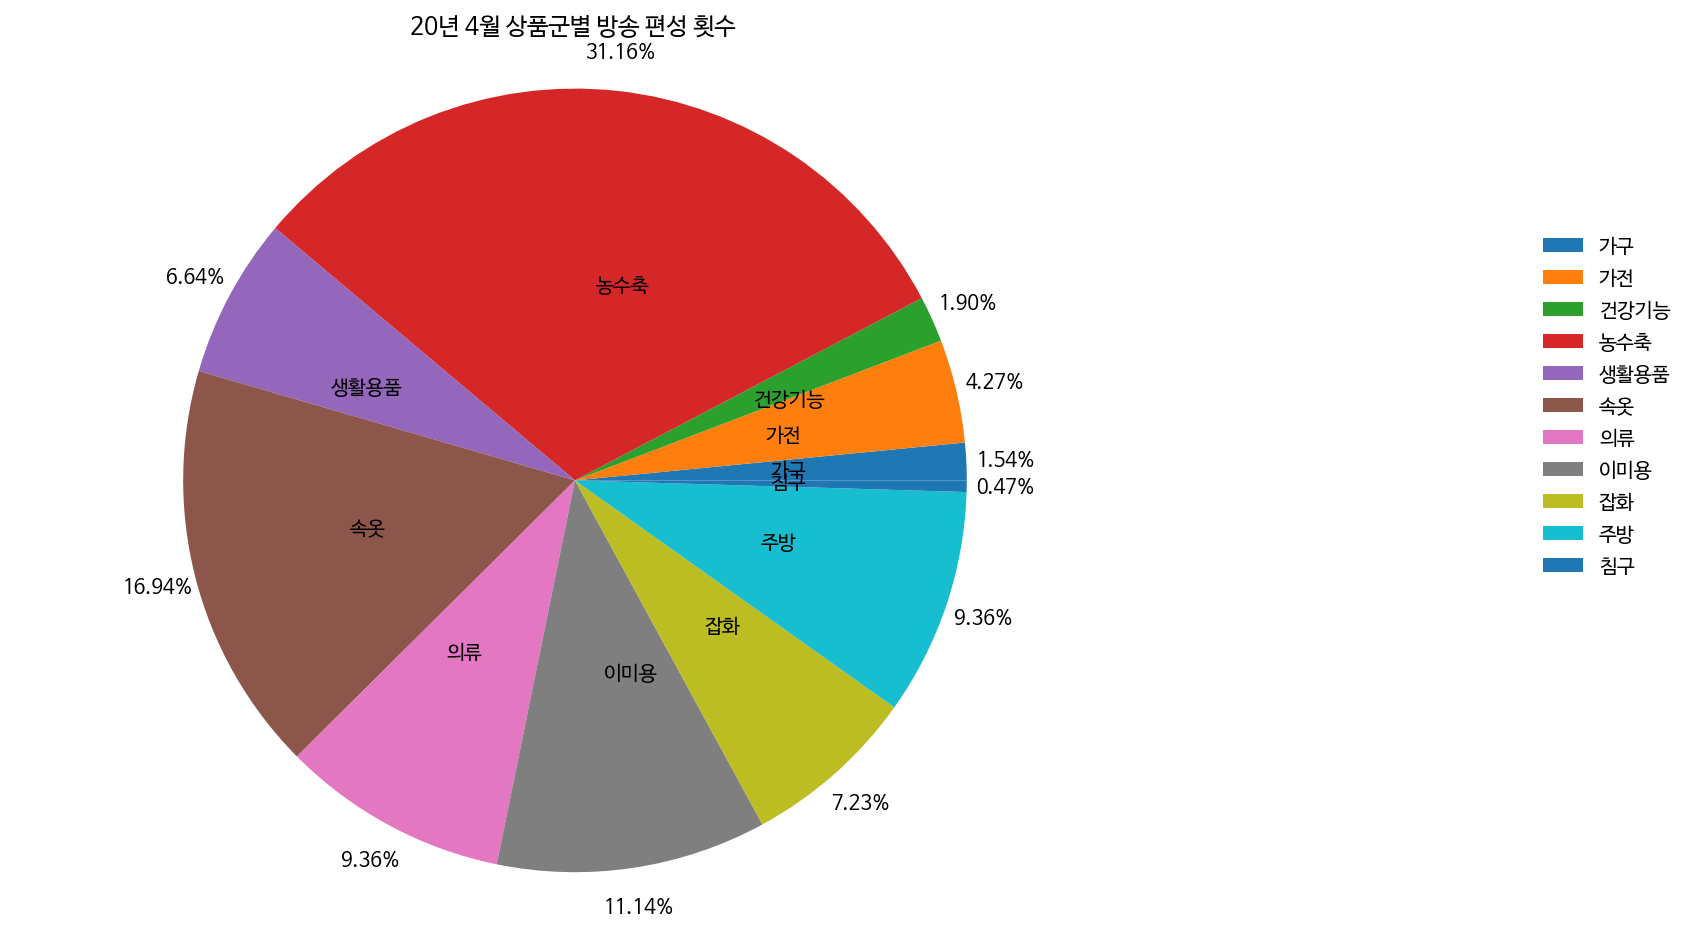

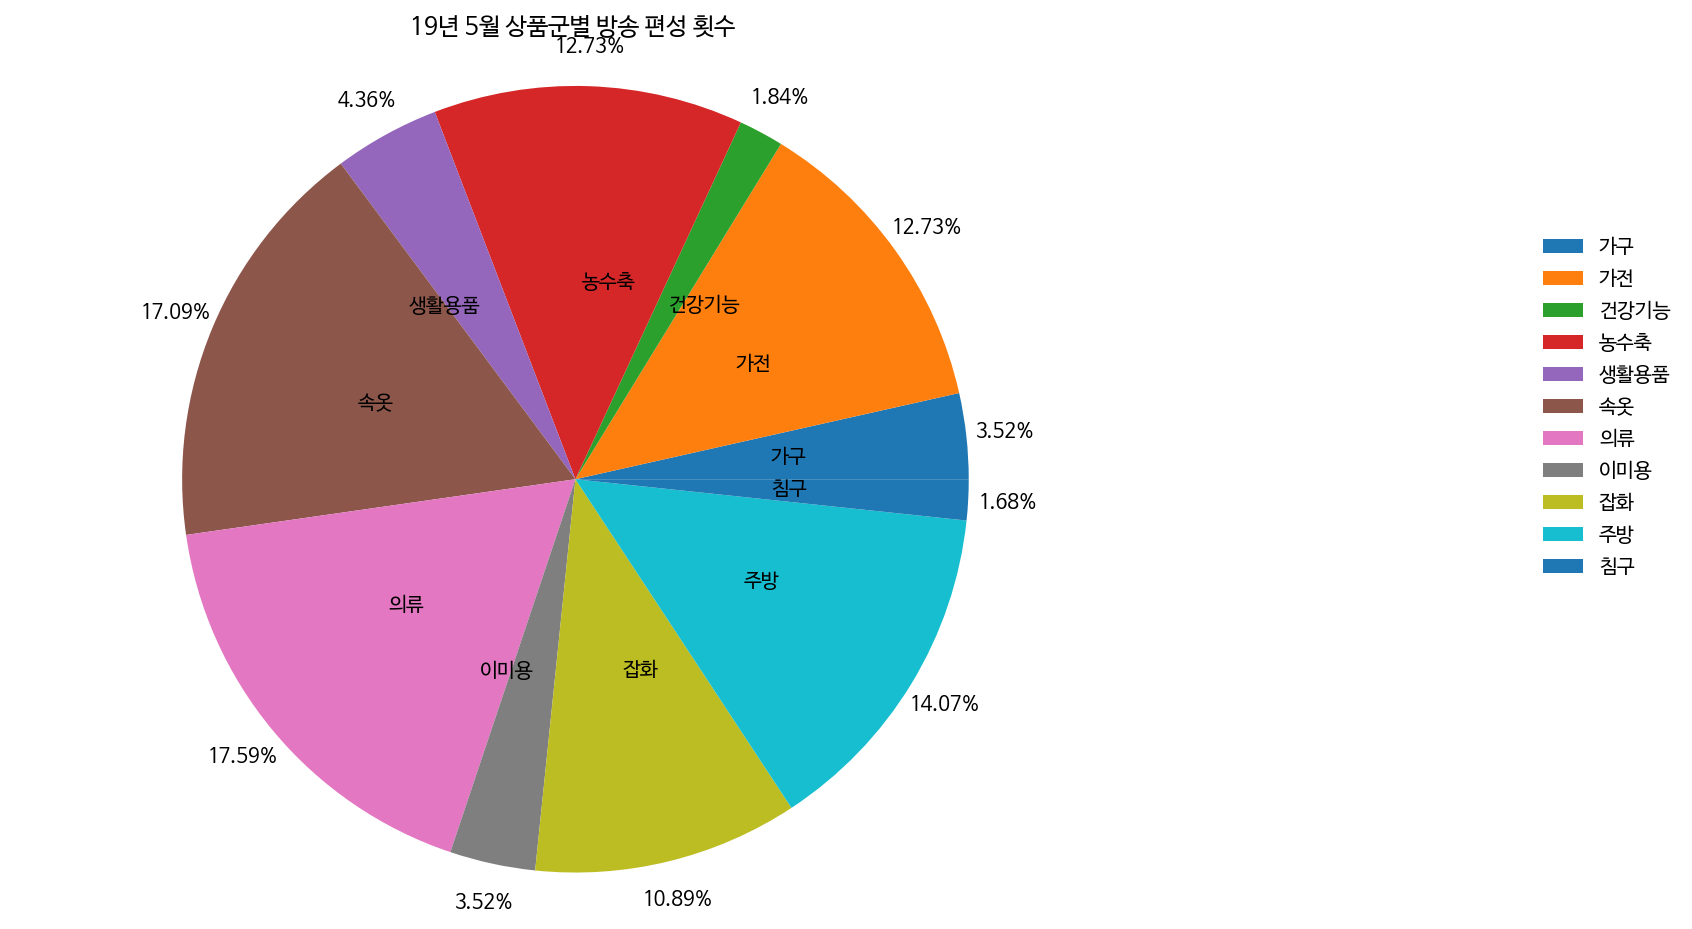

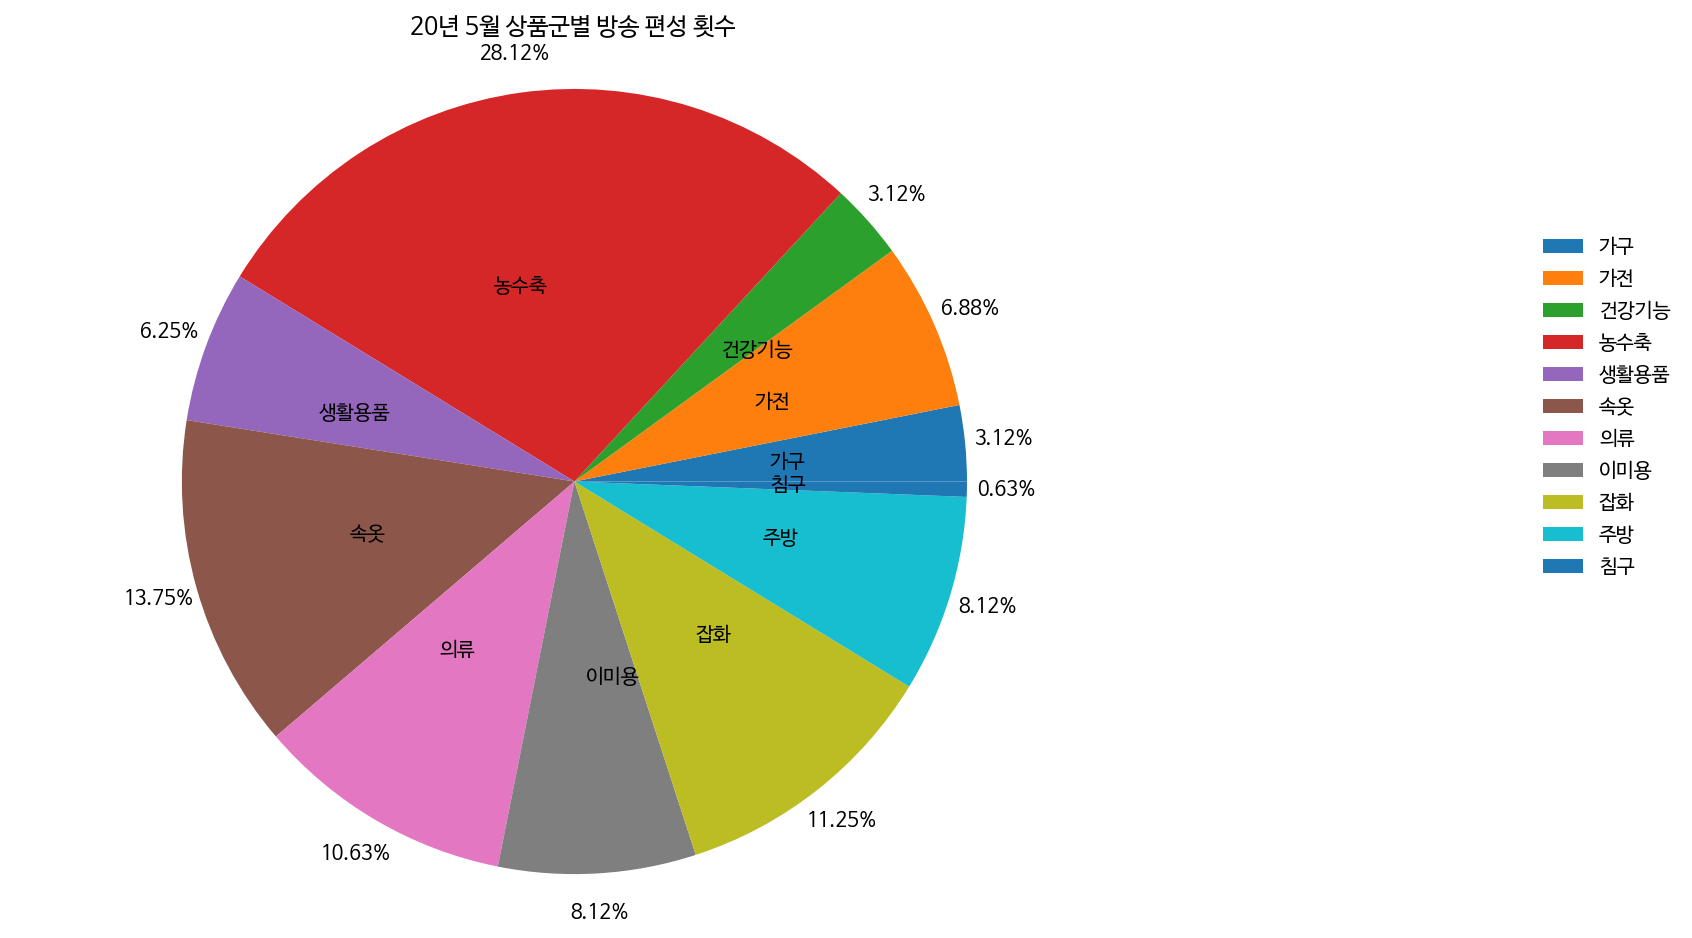

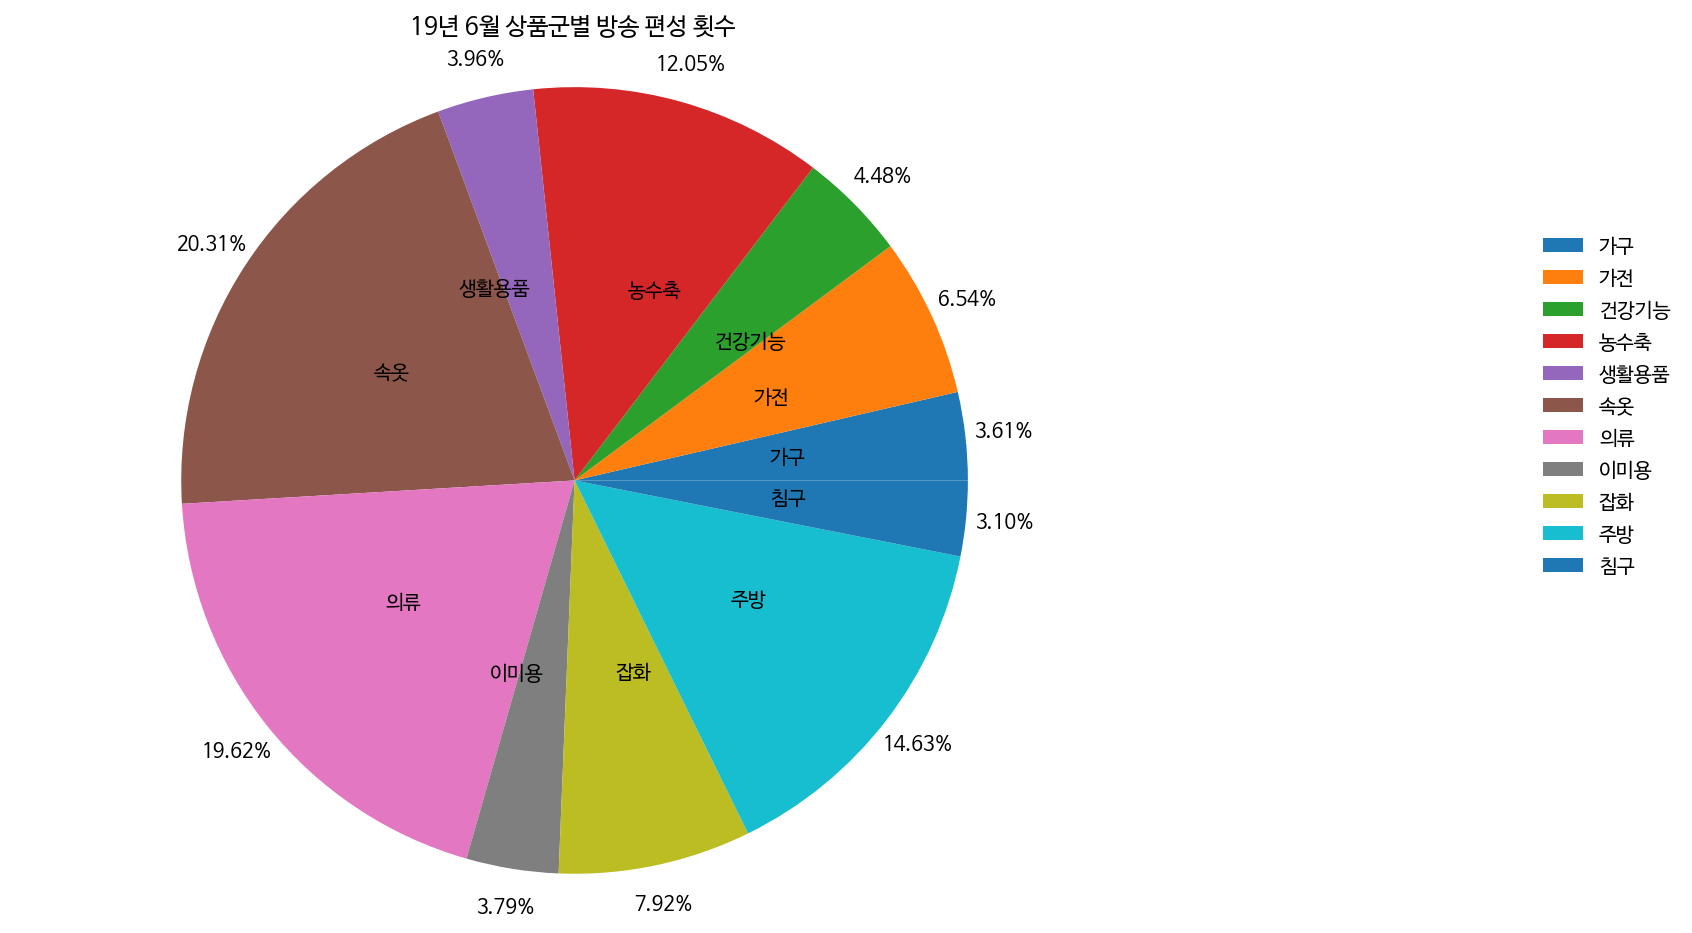

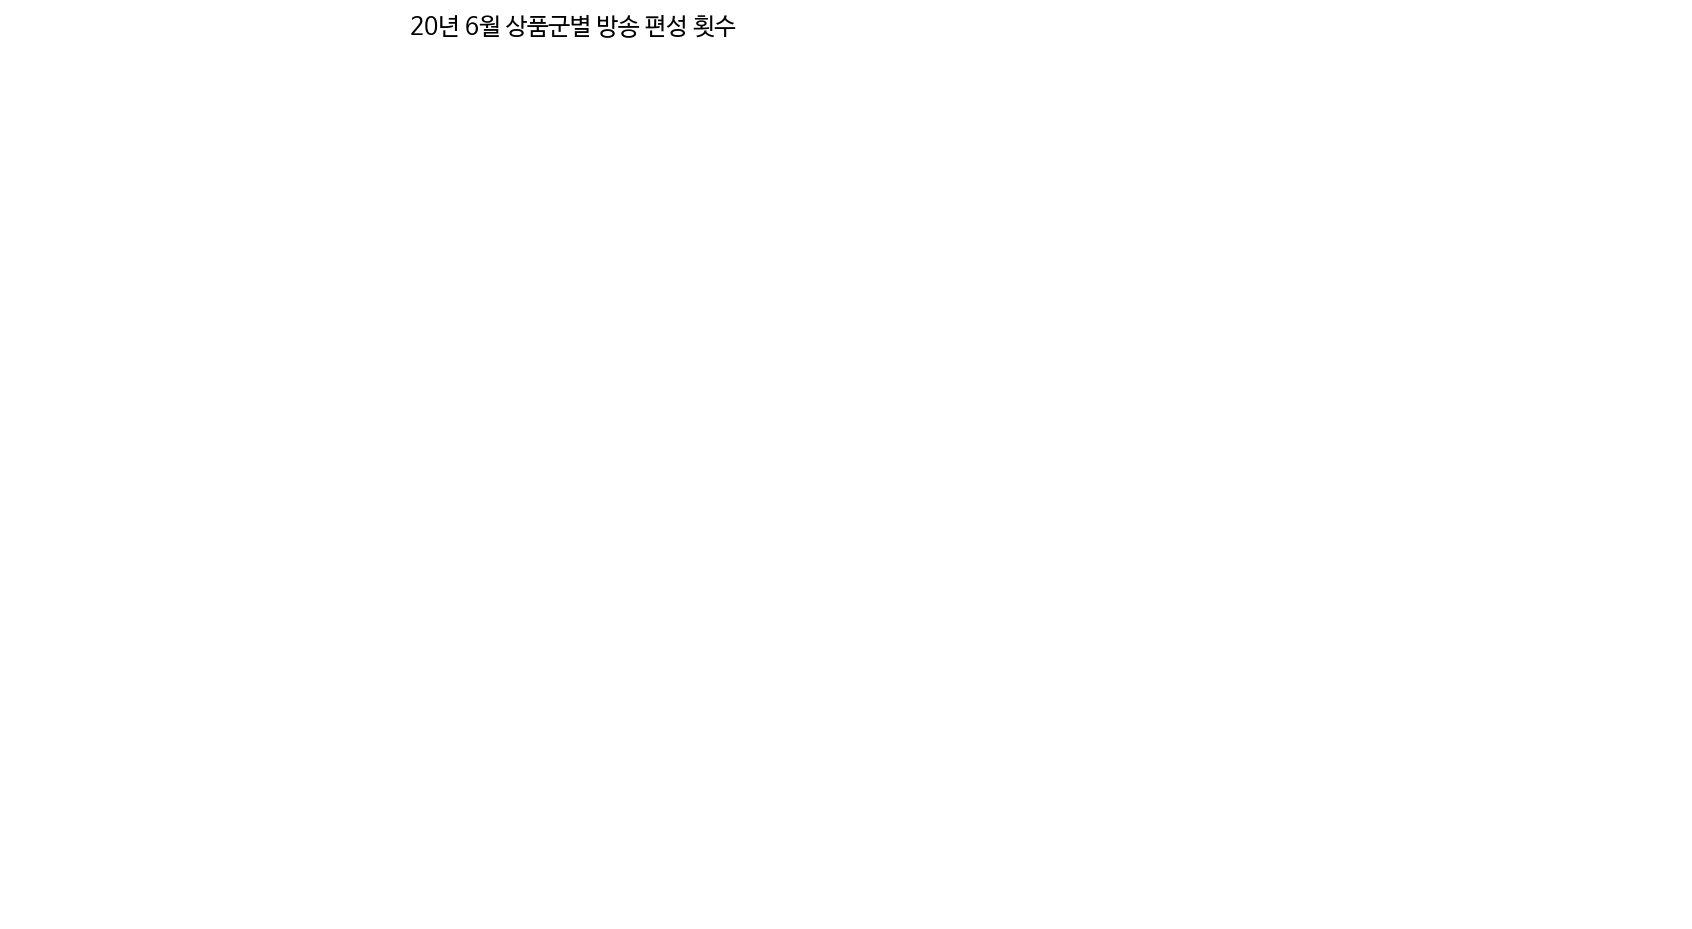

In [70]:
for i in range(1,7,1):
  name = "19년 {}월 상품군별 방송 편성 횟수".format(i)
  monthly_2019 = new_sales[new_sales["month"]==i].groupby("상품군").sum()['count']
  value = monthly_2019.values
  index = monthly_2019.index
  plot_pie(value,index,name)
  plt.savefig("{}.PNG".format(name))
  print(index)
  print(value)
  name = "20년 {}월 상품군별 방송 편성 횟수".format(i)
  monthly_2020 = sales_2020[sales_2020['month']==i].groupby('상품군').count()
  value = monthly_2020['상품명'].values
  index = monthly_2020['상품명'].index
  print(index)
  print(value)
  plot_pie(value,index,name)
  plt.savefig("{}.PNG".format(name))

In [84]:
sales_20_6 = pd.read_excel('/content/2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx',header=1,encoding="CP949")
sales_20_6['count'] = 0
sales_20_6['count'].iloc[0] =1
sales_20_6.drop(sales_20_6[sales_20_6["상품군"]=='무형'].index,inplace=True)
sales_20_6

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,count
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,1
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,0
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,0
...,...,...,...,...,...,...,...,...,...
2883,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,속옷,99000,NaN,0
2884,2020-07-01 00:10:00,NaN,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,속옷,119000,NaN,0
2885,2020-07-01 00:10:00,NaN,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,속옷,119000,NaN,0
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,0


In [85]:
# 동일 시간대 상품 개수 구하기 
for i in range(1,sales_20_6.shape[0]):
  if sales_20_6['마더코드'].iloc[i] == sales_20_6['마더코드'].iloc[i-1]:
    continue
  sales_20_6['count'].iloc[i] =1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [86]:
sales_20_6

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,count
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,1
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,1
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN,0
...,...,...,...,...,...,...,...,...,...
2883,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,속옷,99000,NaN,0
2884,2020-07-01 00:10:00,NaN,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,속옷,119000,NaN,0
2885,2020-07-01 00:10:00,NaN,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,속옷,119000,NaN,0
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,의류,69900,NaN,1


In [87]:
sales_20_6.groupby('상품군').sum()['count']

상품군
가구       13
가전       63
건강기능      4
농수축     117
생활용품     63
속옷       65
의류       49
이미용      56
잡화       98
주방       61
침구        5
Name: count, dtype: int64

Index(['가구', '가전', '건강기능', '농수축', '생활용품', '속옷', '의류', '이미용', '잡화', '주방', '침구'], dtype='object', name='상품군')
[ 13  63   4 117  63  65  49  56  98  61   5]


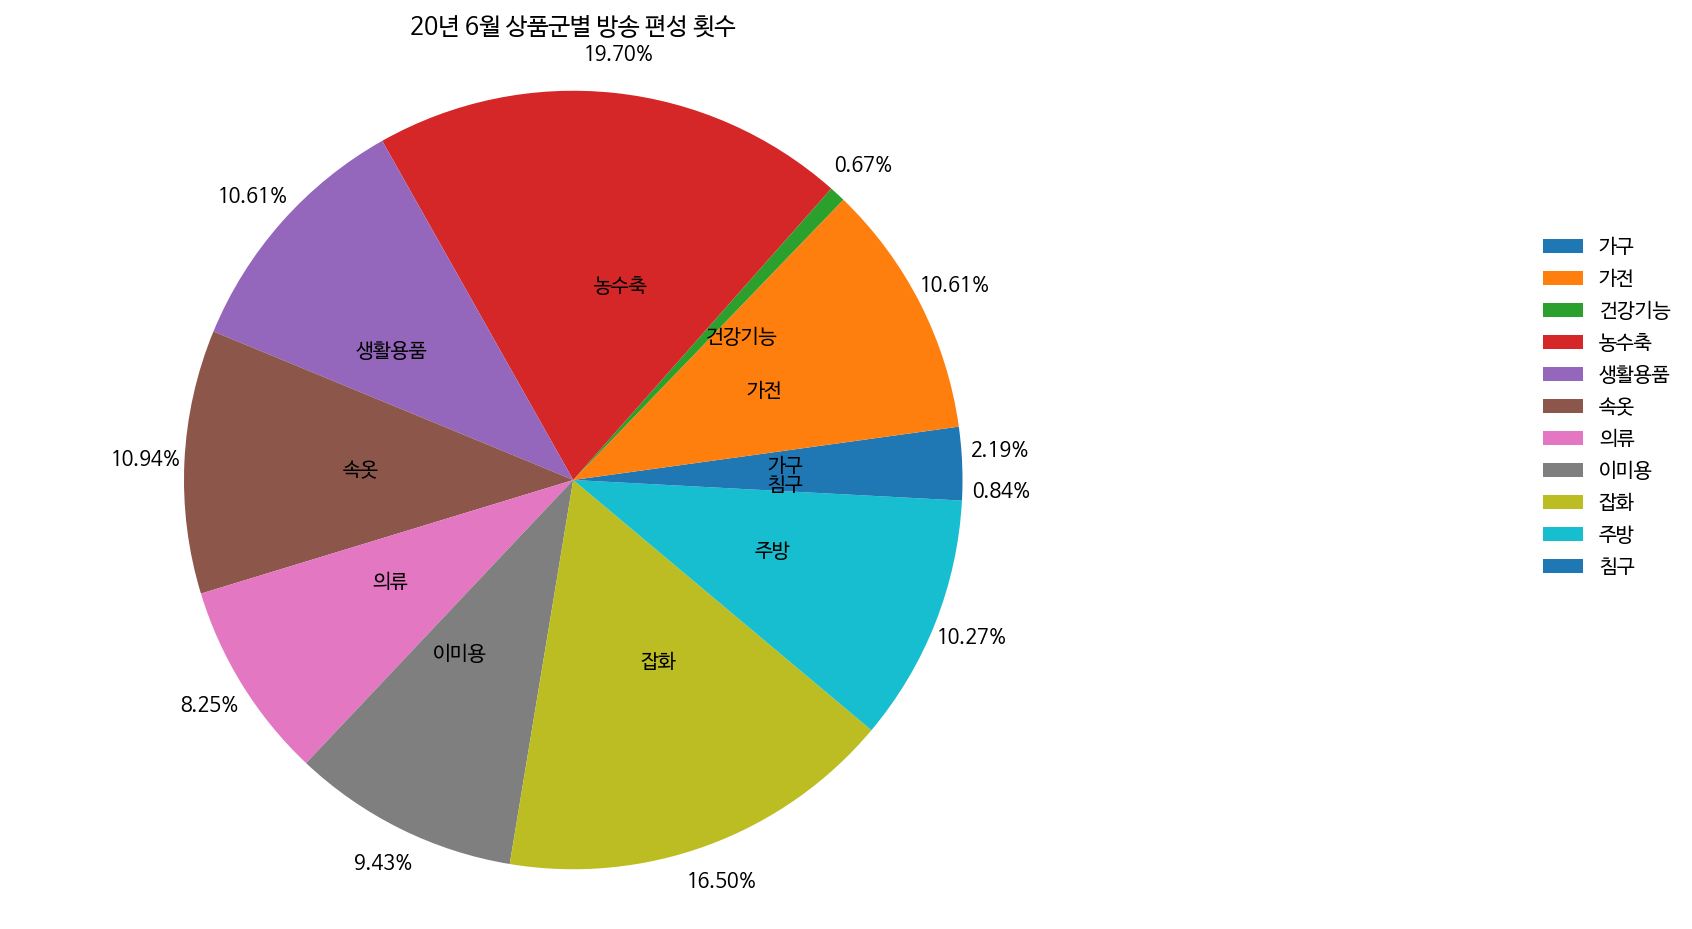

In [88]:
name = "20년 6월 상품군별 방송 편성 횟수"
monthly_20_6 = sales_20_6.groupby('상품군').sum()['count']
value = monthly_20_6.values
index = monthly_20_6.index
plot_pie(value,index,name)
plt.savefig("{}.PNG".format(name))
print(index)
print(value)